# Note:
The data for this project has not been provided in the GitHub repository. However, the Van Allen Probes data is available at the Coordinated Data Analysis Web (CDAWeb) https://cdaweb.gsfc.nasa.gov/ and the OMNI data is available at https://omniweb.gsfc.nasa.gov/.

# Important Physics Point:
This Data Cleaning Algorthm is designed to process this specific mission data. Each step taken in the following code has a scientific basis for being included or excluded. For example, the instruments on the Van Allen Space Probe (Radiation Belt Space Probe RBSP) often lose accuracy when travelling through low L shells, i.e. closer to the Earth due to the increase in the probe's velocity hence their removal.

## The Logic behind this notebook:
Step 1 Load Libraries

Step 2 Data Cleaning Function

Step 3 Load Radial, Azimuthal and Compressional Components

Step 4 Load Ephemeris Values, Time, Magnetic Local Time and Magnitude of the magentic field

Step 5 Complete a nearest neighbour search on Emphemeris Values with a max tolerance of 5 minutes

Step 6 Create specfic MLT bins for each hour

Step 7 Define L shell bins at fixed 'dayside' MLT hours for radial, azimuthal and compressional psd

Step 8 Plot PSD across L shell for each magnetic field component

In [3]:
# Importing Libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from scipy.io import readsav
import scipy
import os 
import glob
from datetime import datetime
from datetime import timedelta
import h5py
import statistics
import seaborn as sns
from matplotlib.ticker import MultipleLocator
from scipy.stats import lognorm

In [5]:
# Set the base directory (modify if needed)
base_directory = r"C:\Users\Furio\Documents\University\Master's\Master's Research Project\Data"

# Original Load Firing Times Function
def load_firing_times(probe_name):
    firing_times_files = {
        "RBSP-A": os.path.join(base_directory, "rbsp-a_thruster_firing_times.txt"),
        "RBSP-B": os.path.join(base_directory, "rbsp-b_thruster_firing_times.txt"),
    }
    time_format = "%Y-%m-%dT%H:%M:%S.%f"
    file_path = firing_times_files[probe_name]
    firing_times = pd.read_csv(file_path, delimiter=',')

    def columns(data_file, Variable):
        if data_file == "RBSP-A":
            Start_Time = "Start Time"
            End_Time = " End Time"
        if data_file == "RBSP-B":
            Start_Time = "#Start Time"
            End_Time = " End Time"

        if Variable == "Start_Time":
            return Start_Time
        if Variable == "End_Time":
            return End_Time

    # The data has an extra 3 zeros than required so we only convert the necessary part to prevent errors.
    start_column = columns(probe_name, "Start_Time")
    start_times = [datetime.strptime(t.strip()[0:26], time_format) for t in firing_times[start_column]]

    end_column = columns(probe_name, "End_Time")
    end_times = [datetime.strptime(t.strip()[0:26], time_format) for t in firing_times[end_column]]
    end_times = [t + timedelta(hours=12) for t in end_times]

    return list(zip(start_times, end_times))

def load_RBSP_variable(satelite, coordinate, variable, key=None):
    # Creating a list of all files
    file_loc = glob.glob(os.path.join(base_directory, satelite, f"*{coordinate}*"))
    overall_variable = []
    overall_time = []
    overall_lshell = []
    overall_b_fft = []
    overall_e_fft = []

    # Loading all files and adding data to lists
    for file_path in file_loc:
        original_data = readsav(file_path)
        variable_original = original_data[variable]
        time_original = original_data['t_dat']  # Needed for thruster removal
        l_shell_original = original_data['l_dat']  # Needed for x < L = 4 removal
        b_fft_original = original_data['b_fft']
        e_fft_original = original_data['e_fft']

        overall_b_fft.append(b_fft_original)
        overall_e_fft.append(e_fft_original)
        overall_variable.append(variable_original)
        overall_time.append(time_original)
        overall_lshell.append(l_shell_original)

    if variable == "f_fft":
        return original_data['f_fft']

    # Concatenating lists
    overall_variable = np.concatenate(overall_variable)
    overall_time = np.concatenate(overall_time)
    overall_lshell = np.concatenate(overall_lshell)
    overall_b_fft = np.concatenate(overall_b_fft)
    overall_e_fft = np.concatenate(overall_e_fft)

    # Removing Nan Values
    if key == "e_fft":
        nan_mask = ~np.isnan(overall_e_fft).any(axis=1)
        overall_variable = overall_variable[nan_mask]
        overall_time = overall_time[nan_mask]
        overall_lshell = overall_lshell[nan_mask]
        overall_b_fft = overall_b_fft[nan_mask]
    else:
        nan_mask = ~np.isnan(overall_b_fft).any(axis=1)
        overall_variable = overall_variable[nan_mask]
        overall_time = overall_time[nan_mask]
        overall_lshell = overall_lshell[nan_mask]
        overall_b_fft = overall_b_fft[nan_mask]

    # Converting time to datetime (t_dat is a timestamp, not a string)
    overall_time = np.array([datetime.fromtimestamp(t) for t in overall_time])

    # ------------------------------------------------------------------
    # Record initial data count BEFORE any filtering
    initial_count = len(overall_time)
    print(f"Initial Data Points: {initial_count}")

    # STEP 1: Removing Thruster Affected Data
    thruster_firing_times = load_firing_times(satelite)
    thruster_firing_mask = np.ones(len(overall_time), dtype=bool)
    for start, end in thruster_firing_times:
        # Create a mask that is False during the thruster firing period
        thruster_firing_mask &= ~((overall_time >= start) & (overall_time <= end))
    count_after_thruster = np.sum(thruster_firing_mask)
    thruster_removed_count = initial_count - count_after_thruster
    print(f"Removed by Thruster: {thruster_removed_count} ({(thruster_removed_count / initial_count) * 100:.2f}%)")

    # Apply thruster filtering
    overall_variable = overall_variable[thruster_firing_mask]
    overall_time = overall_time[thruster_firing_mask]
    overall_lshell = overall_lshell[thruster_firing_mask]
    overall_b_fft = overall_b_fft[thruster_firing_mask]

    # STEP 2: Removing Low L-Shell Data (keep only those with l_shell > 4)
    count_before_lshell = len(overall_time)
    low_lshell_mask = overall_lshell > 4  # True for l_shell values greater than 4
    count_after_lshell = np.sum(low_lshell_mask)
    lshell_removed_count = count_before_lshell - count_after_lshell
    print(f"Removed by L-Shell: {lshell_removed_count} ({(lshell_removed_count / initial_count) * 100:.2f}%)")

    # Apply L-shell filtering
    overall_variable = overall_variable[low_lshell_mask]
    overall_time = overall_time[low_lshell_mask]
    overall_lshell = overall_lshell[low_lshell_mask]
    overall_b_fft = overall_b_fft[low_lshell_mask]

    # If key=="original", return the data now
    if key == "original":
        return overall_variable

    # STEP 3: Removing Values Outside the IQR Range
    count_before_iqr = len(overall_time)
    # Calculate the sum along each row of overall_b_fft
    summed_b_fft = np.array([row.sum() for row in overall_b_fft])

    # Group indices based on overall_lshell bins: [4,5), [5,6), [6,7)
    index_list_4 = np.where((overall_lshell >= 4) & (overall_lshell < 5))[0]
    index_list_5 = np.where((overall_lshell >= 5) & (overall_lshell < 6))[0]
    index_list_6 = np.where((overall_lshell >= 6) & (overall_lshell < 7))[0]

    # Create an overall IQR mask (initialize all as True)
    iqr_mask = np.ones(len(summed_b_fft), dtype=bool)

    # Process each group separately
    for indices in [index_list_4, index_list_5, index_list_6]:
        if len(indices) > 0:
            group_values = summed_b_fft[indices]
            LQ, UQ = np.percentile(group_values, [25, 75])
            IQR = UQ - LQ
            # Keep values within [LQ - 1.5*IQR, UQ + 1.5*IQR]
            group_mask = (group_values >= LQ - 1.5 * IQR) & (group_values <= UQ + 1.5 * IQR)
            iqr_mask[indices] = group_mask

    count_after_iqr = np.sum(iqr_mask)
    iqr_removed_count = count_before_iqr - count_after_iqr
    print(f"Removed by IQR: {iqr_removed_count} ({(iqr_removed_count / initial_count) * 100:.2f}%)")

    # Apply IQR filtering
    overall_variable = overall_variable[iqr_mask]
    overall_time = overall_time[iqr_mask]
    overall_lshell = overall_lshell[iqr_mask]
    overall_b_fft = overall_b_fft[iqr_mask]

    # Final data count after all filtering
    final_count = len(overall_time)
    print(f"Final Data Points: {final_count} ({(final_count / initial_count) * 100:.2f}% remaining)")

    # Return the requested variable
    if variable == "t_dat":
        return overall_time
    if variable == "l_dat":
        return overall_lshell
    else:
        return overall_variable

In [7]:
base_directory = r"C:\Users\Furio\Documents\University\Master's\Master's Research Project\Data"
radial_psd = load_RBSP_variable("RBSP-A", "00", "b_fft")
radial_time = load_RBSP_variable("RBSP-A", "00", "t_dat")
radial_lshell = load_RBSP_variable("RBSP-A", "00", "l_dat")
VAP_freq = load_RBSP_variable("RBSP-A", "00", "f_fft")

Initial Data Points: 672722
Removed by Thruster: 22853 (3.40%)
Removed by L-Shell: 122173 (18.16%)
Removed by IQR: 74043 (11.01%)
Final Data Points: 453653 (67.44% remaining)
Initial Data Points: 672722
Removed by Thruster: 22853 (3.40%)
Removed by L-Shell: 122173 (18.16%)
Removed by IQR: 74043 (11.01%)
Final Data Points: 453653 (67.44% remaining)
Initial Data Points: 672722
Removed by Thruster: 22853 (3.40%)
Removed by L-Shell: 122173 (18.16%)
Removed by IQR: 74043 (11.01%)
Final Data Points: 453653 (67.44% remaining)


In [8]:
azimuthal_psd = load_RBSP_variable("RBSP-A", "11", "b_fft")
azimuthal_time = load_RBSP_variable("RBSP-A", "11", "t_dat")
azimuthal_lshell = load_RBSP_variable("RBSP-A", "11", "l_dat")

Initial Data Points: 672678
Removed by Thruster: 22201 (3.30%)
Removed by L-Shell: 122375 (18.19%)
Removed by IQR: 77717 (11.55%)
Final Data Points: 450385 (66.95% remaining)
Initial Data Points: 672678
Removed by Thruster: 22201 (3.30%)
Removed by L-Shell: 122375 (18.19%)
Removed by IQR: 77717 (11.55%)
Final Data Points: 450385 (66.95% remaining)
Initial Data Points: 672678
Removed by Thruster: 22201 (3.30%)
Removed by L-Shell: 122375 (18.19%)
Removed by IQR: 77717 (11.55%)
Final Data Points: 450385 (66.95% remaining)


In [9]:
# 00 - radial 11 - azimuthal 22 - compressional 
compressional_psd = load_RBSP_variable("RBSP-A", "22", "b_fft")
compressional_time = load_RBSP_variable("RBSP-A", "22", "t_dat")
compressional_lshell = load_RBSP_variable("RBSP-A", "22", "l_dat")

Initial Data Points: 504056
Removed by Thruster: 17029 (3.38%)
Removed by L-Shell: 91623 (18.18%)
Removed by IQR: 42573 (8.45%)
Final Data Points: 352831 (70.00% remaining)
Initial Data Points: 504056
Removed by Thruster: 17029 (3.38%)
Removed by L-Shell: 91623 (18.18%)
Removed by IQR: 42573 (8.45%)
Final Data Points: 352831 (70.00% remaining)
Initial Data Points: 504056
Removed by Thruster: 17029 (3.38%)
Removed by L-Shell: 91623 (18.18%)
Removed by IQR: 42573 (8.45%)
Final Data Points: 352831 (70.00% remaining)


In [13]:
ephemeris_directory = r"C:\Users\Furio\Documents\University\Master's\Master's Research Project\Data\RBSP-A EPHEMERIS"
overall_mag = []
overall_time = []

file_location = glob.glob(os.path.join(ephemeris_directory, "*TS04D*"))
for file_path in file_location:
    data = h5py.File(file_path)
    data_mag = data['Bsc_gsm'][:]
    data_time = data['IsoTime'][:]
    overall_mag.append(data_mag)
    overall_time.append(data_time)

ephemeris_mag = np.concatenate(overall_mag)
ephemeris_time = np.concatenate(overall_time)

print("Mag Shape is" , ephemeris_mag.shape)
print("Time Shape is", ephemeris_time.shape)

ephemeris_directory = r"C:\Users\Furio\Documents\University\Master's\Master's Research Project\Data\RBSP-A EPHEMERIS"
overall_mlt = []
overall_time = []

Mag Shape is (633199, 4)
Time Shape is (633199,)


In [19]:
ephemeris_directory = r"C:\Users\Furio\Documents\University\Master's\Master's Research Project\Data\RBSP-A EPHEMERIS"
overall_mlt = []
overall_time = []

file_location = glob.glob(os.path.join(ephemeris_directory, "*TS04D*"))
for file_path in file_location:
    data = h5py.File(file_path)
    data_mlt = data['EDMAG_MLT'][:]
    data_time = data['IsoTime'][:]
    overall_mlt.append(data_mlt)
    overall_time.append(data_time)

ephemeris_mlt = np.concatenate(overall_mlt)
ephemeris_time = np.concatenate(overall_time)

In [21]:
radial_ephemeris_time = ephemeris_time.copy()
radial_ephemeris_mag = ephemeris_mag.copy()
radial_ephemeris_mlt = ephemeris_mlt.copy()

# --- Step One: Convert Ephemeris time into a datetime object ---
def parse_datetime(time_str):
    # Check if the seconds field is '60'
    if time_str.endswith('60Z'):
        # Replace the leap second with 59
        time_str = time_str[:-3] + '59Z'
    return datetime.strptime(time_str, "%Y-%m-%dT%H:%M:%SZ")

# Convert all ephemeris times, decoding from bytes and parsing
radial_ephemeris_time = np.array([parse_datetime(t.decode('utf-8')) for t in radial_ephemeris_time])

# Step Two: Set a maximum tolerance for index matching
tolerance = timedelta(minutes=5)

# Step Three: Nearest Neighbour Search (Ensure each index is within tolerance!)
valid_indices = []

for i,rad_time in enumerate(radial_time):
    # Find the insertion position in the sorted ephemeris_time array
    pos = np.searchsorted(radial_ephemeris_time, rad_time)
    
    # Compute differences with boundary checks:
    diff_left = abs(rad_time - radial_ephemeris_time[pos - 1]) if pos > 0 else timedelta.max
    diff_right = abs(radial_ephemeris_time[pos] - rad_time) if pos < len(radial_time) else timedelta.max
    
    # Check if the closest match is within the tolerance:
    if min(diff_left, diff_right) <= tolerance:
        valid_indices.append(i)

# Step Four: Downsample Ephemeris time and mlt to valid indices
radial_ephemeris_mag = radial_ephemeris_mag[valid_indices]
radial_ephemeris_time = radial_ephemeris_time[valid_indices]
radial_ephemeris_mlt = radial_ephemeris_mlt[valid_indices]

# Step Five: Double check the shapes of Ephemeris against VAP to test accuracy
print("Ephemeris Time Datashape is,", radial_ephemeris_time.shape)
print("Ephemeris MLT Datashape is,", radial_ephemeris_mlt.shape)
print("Ephemeris Magnetic Field Datashape is,", radial_ephemeris_mag.shape)

print("Van Allen Probe PSD Datashape is,", radial_psd.shape)
print("Van Allen Probe Time Datashape is,", radial_time.shape)

Ephemeris Time Datashape is, (453653,)
Ephemeris MLT Datashape is, (453653,)
Ephemeris Magnetic Field Datashape is, (453653, 4)
Van Allen Probe PSD Datashape is, (453653, 51)
Van Allen Probe Time Datashape is, (453653,)


In [23]:
# Creating a list of arrays that contain psd information at fixed MLT points.
radial_mlt_index_1 = []
radial_mlt_index_2 = []
radial_mlt_index_3 = []
radial_mlt_index_4 = []
radial_mlt_index_5 = []
radial_mlt_index_6 = []
radial_mlt_index_7 = []
radial_mlt_index_8 = []
radial_mlt_index_9 = []
radial_mlt_index_10 = []
radial_mlt_index_11 = []
radial_mlt_index_12 = []
radial_mlt_index_13 = []
radial_mlt_index_14 = []
radial_mlt_index_15 = []
radial_mlt_index_16 = []
radial_mlt_index_17 = []
radial_mlt_index_18 = []
radial_mlt_index_19 = []
radial_mlt_index_20 = []
radial_mlt_index_21 = []
radial_mlt_index_22 = []
radial_mlt_index_23 = []
radial_mlt_index_24 = []

for i in range(len(radial_ephemeris_mlt)):
    if radial_ephemeris_mlt[i] >= 0 and radial_ephemeris_mlt[i] <= 1:
        radial_mlt_index_1.append(i)
    elif radial_ephemeris_mlt[i] > 1 and radial_ephemeris_mlt[i] <= 2:
        radial_mlt_index_2.append(i)
    elif radial_ephemeris_mlt[i] > 2 and radial_ephemeris_mlt[i] <= 3:
        radial_mlt_index_3.append(i)
    elif radial_ephemeris_mlt[i] > 3 and radial_ephemeris_mlt[i] <= 4:
        radial_mlt_index_4.append(i)
    elif radial_ephemeris_mlt[i] > 4 and radial_ephemeris_mlt[i] <= 5:
        radial_mlt_index_5.append(i)
    elif radial_ephemeris_mlt[i] > 5 and radial_ephemeris_mlt[i] <= 6:
        radial_mlt_index_6.append(i)
    elif radial_ephemeris_mlt[i] > 6 and radial_ephemeris_mlt[i] <= 7:
        radial_mlt_index_7.append(i)
    elif radial_ephemeris_mlt[i] > 7 and radial_ephemeris_mlt[i] <= 8:
        radial_mlt_index_8.append(i)
    elif radial_ephemeris_mlt[i] > 8 and radial_ephemeris_mlt[i] <= 9:
        radial_mlt_index_9.append(i)
    elif radial_ephemeris_mlt[i] > 9 and radial_ephemeris_mlt[i] <= 10:
        radial_mlt_index_10.append(i)
    elif radial_ephemeris_mlt[i] > 10 and radial_ephemeris_mlt[i] <= 11:
        radial_mlt_index_11.append(i)
    elif radial_ephemeris_mlt[i] > 11 and radial_ephemeris_mlt[i] <= 12:
        radial_mlt_index_12.append(i)
    elif radial_ephemeris_mlt[i] > 12 and radial_ephemeris_mlt[i] <= 13:
        radial_mlt_index_13.append(i)
    elif radial_ephemeris_mlt[i] > 13 and radial_ephemeris_mlt[i] <= 14:
        radial_mlt_index_14.append(i)
    elif radial_ephemeris_mlt[i] > 14 and radial_ephemeris_mlt[i] <= 15:
        radial_mlt_index_15.append(i)
    elif radial_ephemeris_mlt[i] > 15 and radial_ephemeris_mlt[i] <= 16:
        radial_mlt_index_16.append(i)
    elif radial_ephemeris_mlt[i] > 16 and radial_ephemeris_mlt[i] <= 17:
        radial_mlt_index_17.append(i)
    elif radial_ephemeris_mlt[i] > 17 and radial_ephemeris_mlt[i] <= 18:
        radial_mlt_index_18.append(i)
    elif radial_ephemeris_mlt[i] > 18 and radial_ephemeris_mlt[i] <= 19:
        radial_mlt_index_19.append(i)
    elif radial_ephemeris_mlt[i] > 19 and radial_ephemeris_mlt[i] <= 20:
        radial_mlt_index_20.append(i)
    elif radial_ephemeris_mlt[i] > 20 and radial_ephemeris_mlt[i] <= 21:
        radial_mlt_index_21.append(i)
    elif radial_ephemeris_mlt[i] > 21 and radial_ephemeris_mlt[i] <= 22:
        radial_mlt_index_22.append(i)
    elif radial_ephemeris_mlt[i] > 22 and radial_ephemeris_mlt[i] <= 23:
        radial_mlt_index_23.append(i)
    elif radial_ephemeris_mlt[i] > 23 and radial_ephemeris_mlt[i] <= 24:
        radial_mlt_index_24.append(i)

In [37]:
radial_dist_index_5 = []
radial_dist_index_6 = []
radial_dist_index_7 = []

dayside_mlt_index =  np.concatenate([radial_mlt_index_11,radial_mlt_index_12,radial_mlt_index_13])

idx_L5 = np.where((radial_lshell > 4) & (radial_lshell <= 5))[0]
idx_L6 = np.where((radial_lshell > 5) & (radial_lshell <= 6))[0]
idx_L7 = np.where((radial_lshell > 6) & (radial_lshell <= 7))[0]


radial_dist_index_5 = np.intersect1d(idx_L5, dayside_mlt_index)
radial_dist_index_6 = np.intersect1d(idx_L6, dayside_mlt_index)
radial_dist_index_7 = np.intersect1d(idx_L7, dayside_mlt_index)


In [39]:
psd_rad_dist_5  = radial_psd[radial_dist_index_5,2]
psd_rad_dist_6  = radial_psd[radial_dist_index_6,2]
psd_rad_dist_7  = radial_psd[radial_dist_index_7,2]

In [41]:
radial_dist_index_5 = []
radial_dist_index_6 = []
radial_dist_index_7 = []

dayside_mlt_index =  np.concatenate([radial_mlt_index_11,radial_mlt_index_12,radial_mlt_index_13])

idx_L5 = np.where((azimuthal_lshell > 4) & (azimuthal_lshell <= 5))[0]
idx_L6 = np.where((azimuthal_lshell > 5) & (azimuthal_lshell <= 6))[0]
idx_L7 = np.where((azimuthal_lshell > 6) & (azimuthal_lshell <= 7))[0]


radial_dist_index_5 = np.intersect1d(idx_L5, dayside_mlt_index)
radial_dist_index_6 = np.intersect1d(idx_L6, dayside_mlt_index)
radial_dist_index_7 = np.intersect1d(idx_L7, dayside_mlt_index)


In [43]:
azi_psd_rad_dist_5  = azimuthal_psd[radial_dist_index_5,2]
azi_psd_rad_dist_6  = azimuthal_psd[radial_dist_index_6,2]
azi_psd_rad_dist_7  = azimuthal_psd[radial_dist_index_7,2]

In [45]:
radial_dist_index_5 = []
radial_dist_index_6 = []
radial_dist_index_7 = []

dayside_mlt_index =  np.concatenate([radial_mlt_index_11,radial_mlt_index_12,radial_mlt_index_13])

idx_L5 = np.where((compressional_lshell > 4) & (compressional_lshell <= 5))[0]
idx_L6 = np.where((compressional_lshell > 5) & (compressional_lshell <= 6))[0]
idx_L7 = np.where((compressional_lshell > 6) & (compressional_lshell <= 7))[0]


radial_dist_index_5 = np.intersect1d(idx_L5, dayside_mlt_index)
radial_dist_index_6 = np.intersect1d(idx_L6, dayside_mlt_index)
radial_dist_index_7 = np.intersect1d(idx_L7, dayside_mlt_index)

compressional_psd_rad_dist_5  = compressional_psd[radial_dist_index_5,2]
compressional_psd_rad_dist_6  = compressional_psd[radial_dist_index_6,2]
compressional_psd_rad_dist_7  = compressional_psd[radial_dist_index_7,2]

times_rad_dist_5 = compressional_time[radial_dist_index_5]
times_rad_dist_6 = compressional_time[radial_dist_index_6]
times_rad_dist_7 = compressional_time[radial_dist_index_7]

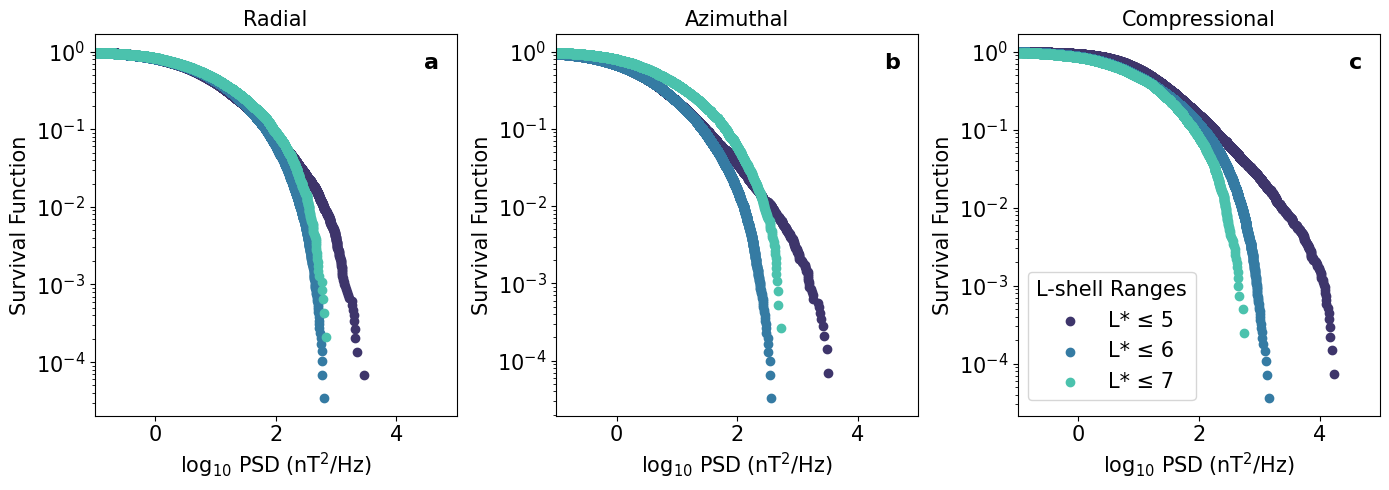

In [47]:
psd_list = [psd_rad_dist_5, psd_rad_dist_6, psd_rad_dist_7]
azi_psd_list = [azi_psd_rad_dist_5,azi_psd_rad_dist_6,azi_psd_rad_dist_7]
compressional_psd_list = [compressional_psd_rad_dist_5,compressional_psd_rad_dist_6,compressional_psd_rad_dist_7]
radial_dist_list = [5,6,7] # In Re

colors  = sns.color_palette("mako", 3)

fig, ax = plt.subplots(1,3, figsize = (14,5))
ax[0].set_title("Radial", fontsize = 15)
ax[1].set_title("Azimuthal", fontsize = 15)
ax[2].set_title("Compressional", fontsize = 15)

for a in ax.flatten():
    a.set_xlim(-1,5)
    a.set_yscale("log")
    a.set_ylabel("Survival Function", fontsize = 15)
    a.set_xlabel(r"$\log_{10}\,\mathrm{PSD}\;(\mathrm{nT}^{2}/\mathrm{Hz})$",
                     fontsize=15)
    a.tick_params(axis='x', labelsize=15)
    a.tick_params(axis='y', labelsize=15)
    

for i in range(0,3):
    psd = psd_list[i]
    logged_psd = np.log10(psd)

    azimuthal_psd_ = azi_psd_list[i]
    logged_azimuthal_psd = np.log10(azimuthal_psd_)

    compressional_psd_ = compressional_psd_list[i]
    logged_compressional_psd = np.log10(compressional_psd_)
    
    x = np.sort(logged_psd)
    y = 1 - (np.arange(len(x)) / float(len(x)))

    x2 = np.sort(logged_azimuthal_psd)
    y2 = 1 - (np.arange(len(x2)) / float(len(x2)))

    x3 = np.sort(logged_compressional_psd)
    y3 = 1 - (np.arange(len(x3)) / float(len(x3)))
    
    ax[0].scatter(x,y, label = f'L* ≤ {radial_dist_list[i]}', color = colors[i])
    ax[1].scatter(x2,y2, label = f'L* ≤ {radial_dist_list[i]}',color = colors[i])
    ax[2].scatter(x3,y3, label = f'L* ≤ {radial_dist_list[i]}',color = colors[i])

for idx, a in enumerate(ax):
    a.text(0.95, 0.95, chr(97 + idx),          # 'a', 'b', 'c'
           transform=a.transAxes,
           fontsize=16, fontweight="bold",
           va="top", ha="right")


#plt.title("Power Spectral Density Across L Shell", fontsize = 15)
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=1, bbox_to_anchor=(0.865, 0.467), title = "L-shell Ranges", fontsize = 15, title_fontsize=15)
plt.tight_layout()
#plt.savefig("3 Component Change in Lshell at fixed MLT.jpg")
plt.show()